### Objectives

The primary aim of this notebook is to thoroughly analyze the dataset’s variables and their interconnections. This analysis will inform the selection and development of machine learning models that align with overarching project goals to enrich understanding of our portfolio of projects and identify patterns in the types of projects driving revenue. The insights gained will not only influence the choice of models but also identify necessary preprocessing steps to prepare the dataset for machine learning applications.

Additionally, this exploratory analysis serves a secondary purpose: to validate business hypotheses and extract initial findings that could provide immediate value.

### Package  & Data Imports + Path Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt

In [2]:
# Enabling importing of modules from utils directory

# construct path to utils directory
path_to_utils = os.path.abspath(os.path.join(os.path.dirname('__file__'), 'utils')) 

# avoid adding multiple times
if path_to_utils not in sys.path:
    sys.path.append(path_to_utils)

In [3]:
from utils.kseda import plot_histograms, plot_boxplots, filter_iqr, plot_IQRhistograms, plot_freq_dist

In [4]:
df = pd.read_excel("./data/cleaned_data.xlsx")
df.head(3)

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal,name2,name_len2,name_len_clean_2
0,1538064060,MAGIC PIXEL - Bluetooth full color LED display,15000.0,5933.0,failed,False,GB,GBP,2016-03-19 09:31:29,2016-03-19 09:31:32,...,18,2016,9,62,30,30,21450,MAGIC PIXEL - Bluetooth full color LED display,8,8
1,556771080,SmartPi - Turn your Raspberry Pi into a SmartM...,9000.0,16552.0,successful,False,DE,EUR,2016-04-03 08:05:09,2016-04-03 08:05:10,...,18,2016,8,9,45,45,10034,SmartPi - Turn your Raspberry Pi into a SmartM...,9,6
2,839314928,PlantSitter - The World's Smartest Plant Monit...,60000.0,43234.0,canceled,False,US,USD,2016-03-29 08:01:08,2016-03-28 09:46:41,...,18,2016,8,18,40,39,60000,PlantSitter - The World's Smartest Plant Monit...,8,7


### Preparation

Earlier QA preprocessing had minimal column removal for flexibility preparing the dataset for alternative future purposes. As our purpose is known in this case, certain columns can be dropped: ID columns, non-US currency columns, and previous versions of the `name` columns.

In [5]:
to_drop = ['id', 'goal', 'pledged', 'static_usd_rate', 'name', 'name_len', 'name_len_clean' ]
for col in to_drop:
    if col in df.columns:
        df.drop(columns = [col], inplace= True)

Preparing lists of columns which are better analyzed seperately.

In [6]:
datetimecols = ['deadline_month','deadline_day','deadline_yr','deadline_hr','state_changed_at_month','state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr','created_at_month','created_at_day','created_at_yr','created_at_hr',
                'launched_at_month', 'launched_at_day', 'launched_at_yr','launched_at_hr', 'created_at_weekday', 'launched_at_weekday', 'deadline_weekday', 'state_changed_at_weekday'] 

timestampcols = ['deadline', 'state_changed_at', 'created_at', 'launched_at']

catcols = df.select_dtypes(include=['object', 'bool']).columns.to_list()

for col in datetimecols:
    if col in catcols:
        catcols.remove(col)

numcols = [col for col in df.columns if col not in catcols + datetimecols + timestampcols]

if 'name2' in catcols:
    catcols.remove('name2')

fundingcols = ['backers_count', 'usd_pledged', 'usd_goal']

print("Numerical Variables: ", numcols)
print("Categorical Variables: ", catcols)

Numerical Variables:  ['backers_count', 'usd_pledged', 'blurb_len', 'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'usd_goal', 'name_len2', 'name_len_clean_2']
Categorical Variables:  ['state', 'disable_communication', 'country', 'currency', 'staff_pick', 'category', 'spotlight']


### Univariate Analysis

#### Descriptive Statistics on Numerical Variables

In [7]:
pd.set_option('display.max_columns', None)
df[numcols].describe().round(2)

,backers_count,usd_pledged,blurb_len,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal,name_len2,name_len_clean_2
count,15474.00,15474.00,15470.00,15470.00,15474.00,15474.00,15474.00,1.547400e+04,15474.00,15474.00
mean,181.17,19975.49,18.99,13.03,46.91,34.68,32.02,9.474142e+04,5.80,4.73
std,1287.83,114439.55,4.64,3.26,101.77,11.98,13.67,1.462852e+06,2.84,2.25
min,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.000000e+00,1.00,0.00
25%,2.00,24.86,17.00,11.00,3.00,30.00,29.00,4.000000e+03,3.00,3.00
50%,12.00,676.84,20.00,13.00,13.00,30.00,30.00,1.250000e+04,6.00,5.00
75%,63.00,5896.88,22.00,15.00,43.00,40.00,35.00,4.482050e+04,8.00,6.00
max,105857.00,6225354.98,35.00,30.00,1528.00,91.00,91.00,1.000000e+08,16.00,14.00


**Observations**
* Observing zero minimums for backers count and funds raised (`usd_pledged`) seems logical as projects could be canceled, suspended, or simply very unsuccesful. The dataset does not include projects which are in an actively fundraising state, so this explanation for zero minimums would not apply. It may be beneficial to exclude suspended projects from the clustering analysis as identifying patterns for that status is not as relevant to the analytical objective.
* For funding related variables (`usd_goal`, `usd_pledged`, and `backers_count`) and project timeline variables (`create_to_launch_days`, `launch_to_deadline_days`, and `launch_to_state_change_days`), the interquartile ranges (IQRs) are fairly compact with notable positive extremes on the positive. Investigating the distribution and relationship to other variables will be important for determining whether these outliers represent a meaningful segment of projects or are anomolies to exclude.


#### Data Distributions - Numerical

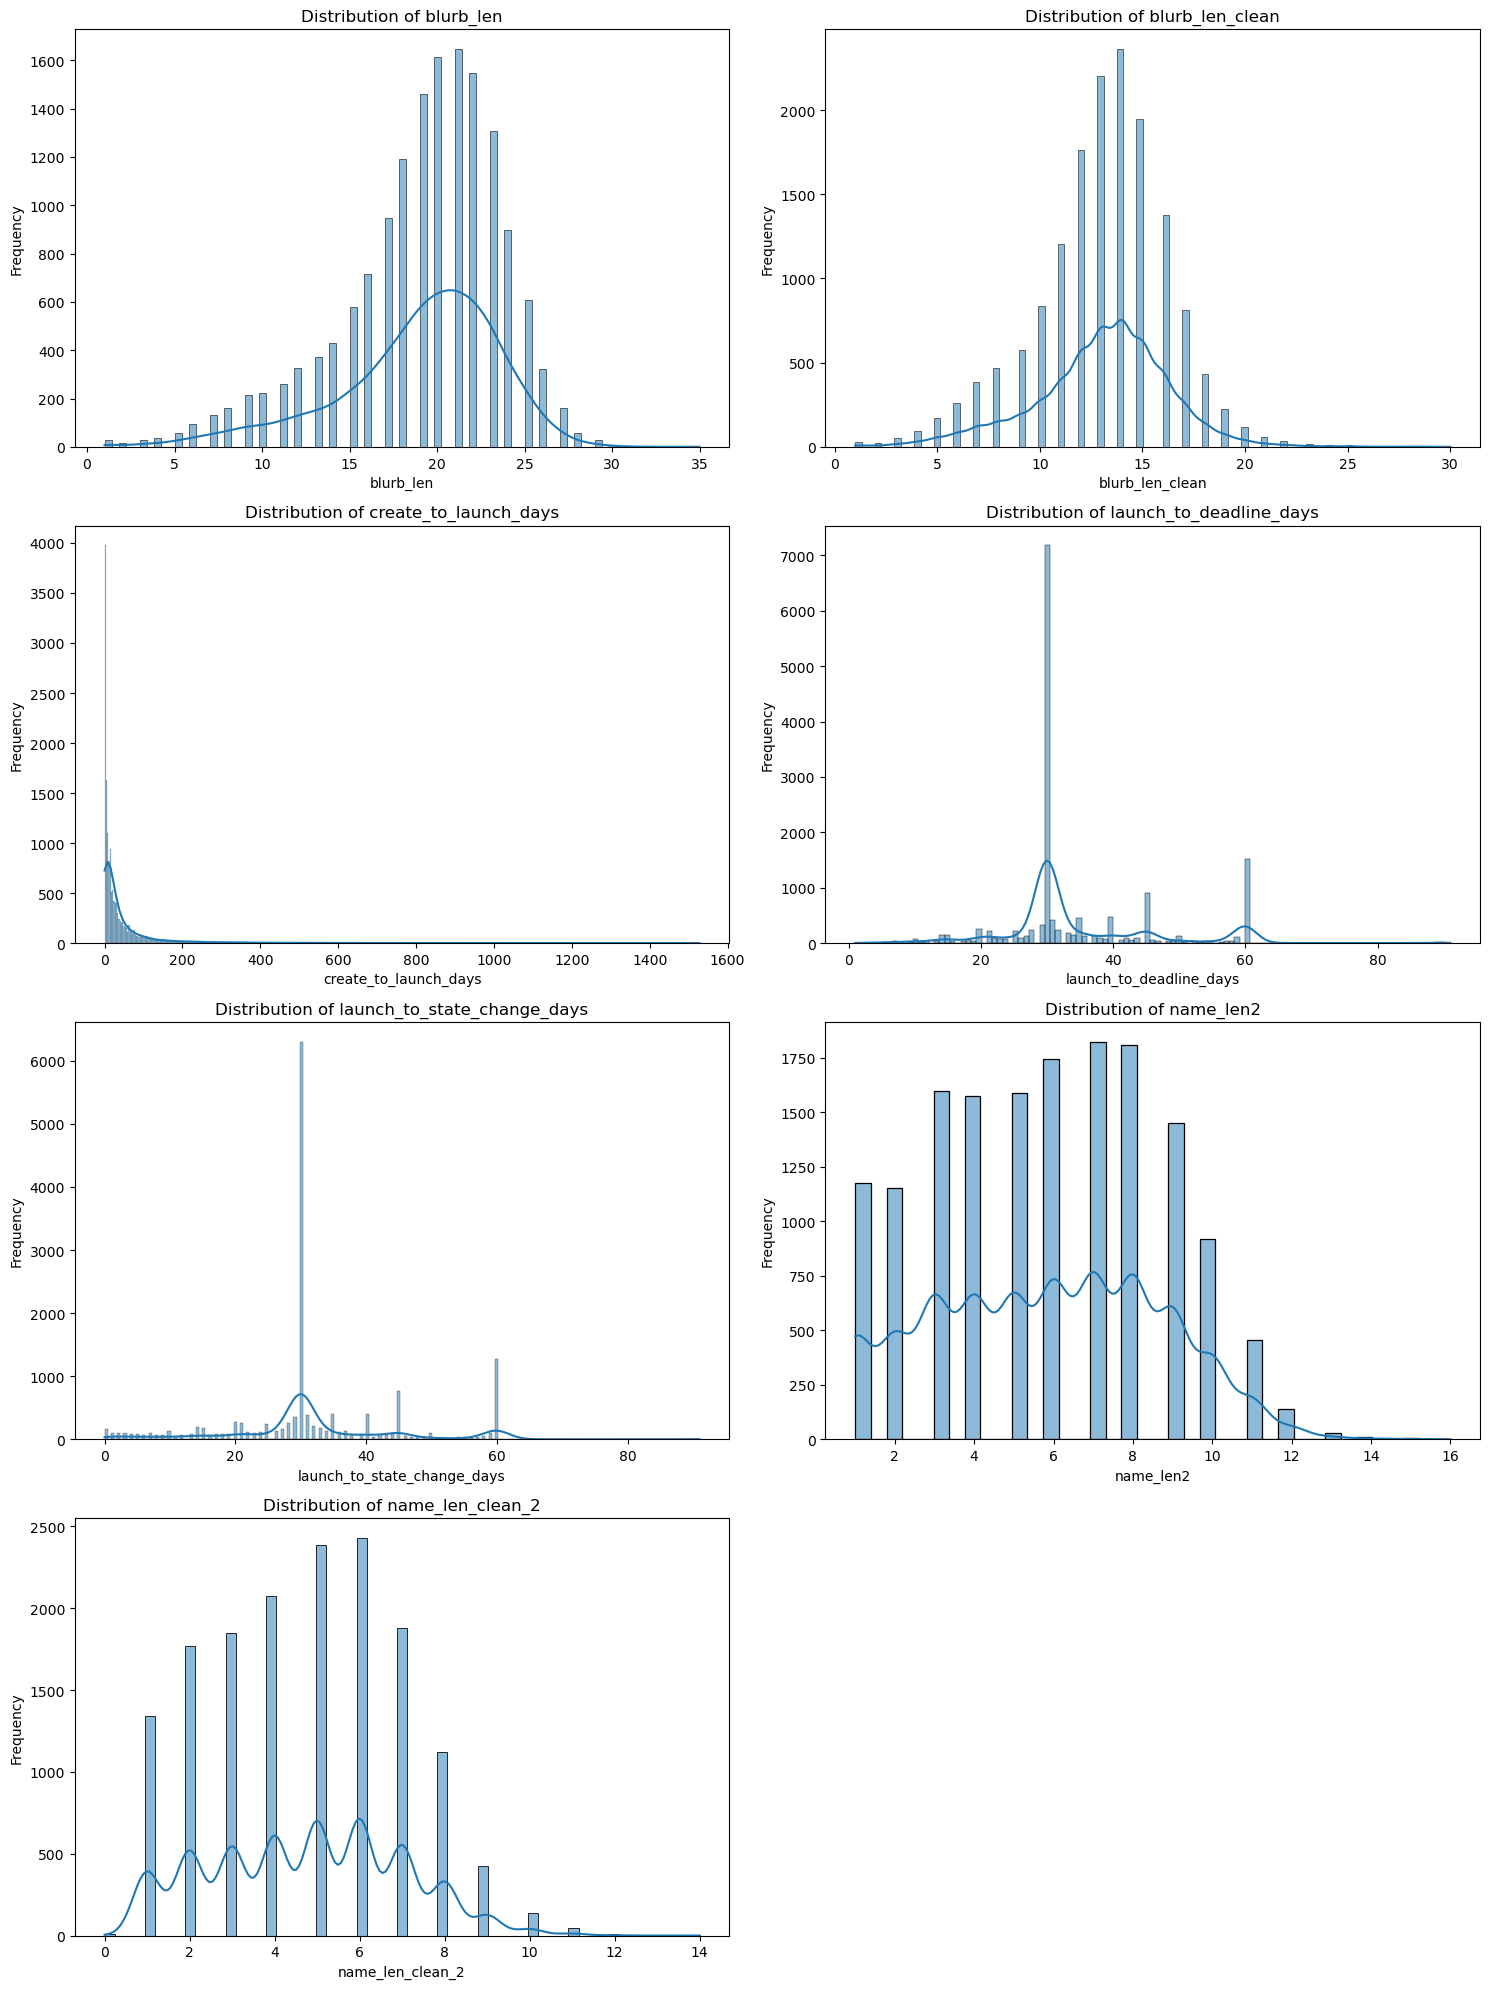

In [7]:
# Exclude funding columns to handle separately
filteredcols = [col for col in numcols if col not in fundingcols]

fig, axes = plot_histograms(df, filteredcols, kde = True, n_cols=2)
plt.show()

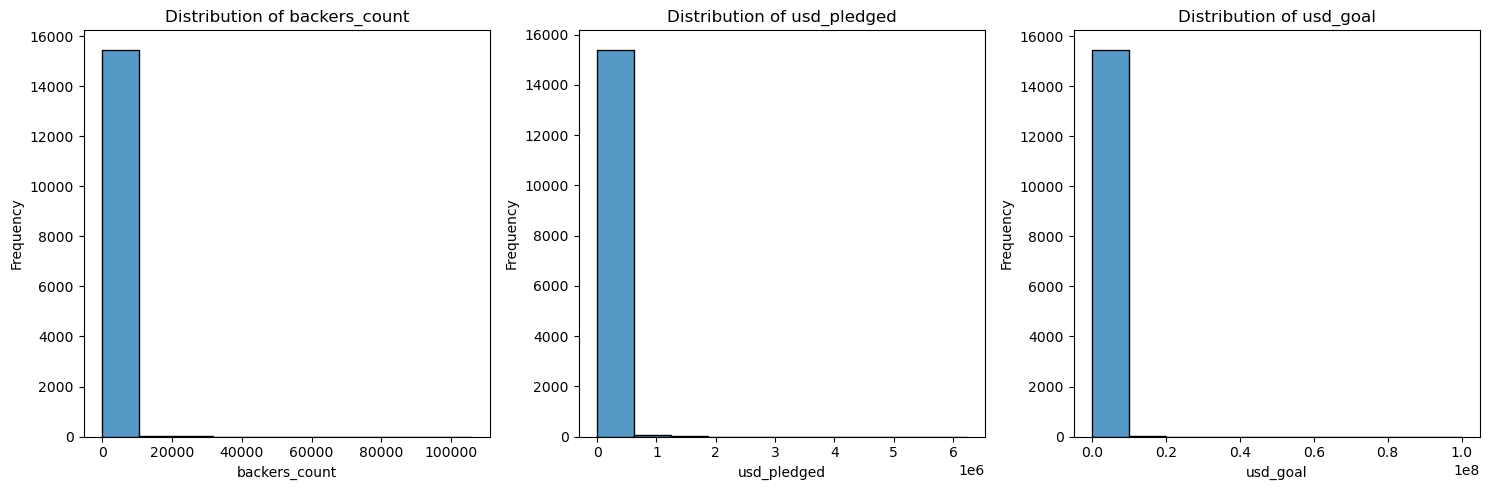

In [8]:
fig, axes = plot_histograms(df, fundingcols, n_cols=3, bins=10)
plt.show()

**Observations**
* The extreme right skew for funding related variables aligns with the data range observations from descriptive stats. The interpretation for `create_to_launch_days` is similarly aligned. 
* By contrast, plotting `launch_to_deadline_days` in this way reveals a bimodal distribution with the most significant peak around 30 days and minor around 60 days. The major peak is consistent with platform guidance to have funding periods of 30 days or less. The bimodal distribution observed for `launch_to_state_change_days` follows a similar pattern. 
* The distribution for the length of projects' descriptive blurbs, `blurb_len`, is skewed left slightly but with stop words removed in `blurb_len_clean` it becomes a fairly normal distribution. With mean, median and mode pointing to a central tendency around 14 meainingful words, it suggests a commonality in how creators choose to describe projects, potentially adhering to informal or platform norms about how much textual information to provide to engage potential backers. Similar implications may be drawn from the unimaodal and roughly symmetircal distrubtions for the project name length variables.

#### Extreme Values - Funding Related Variables

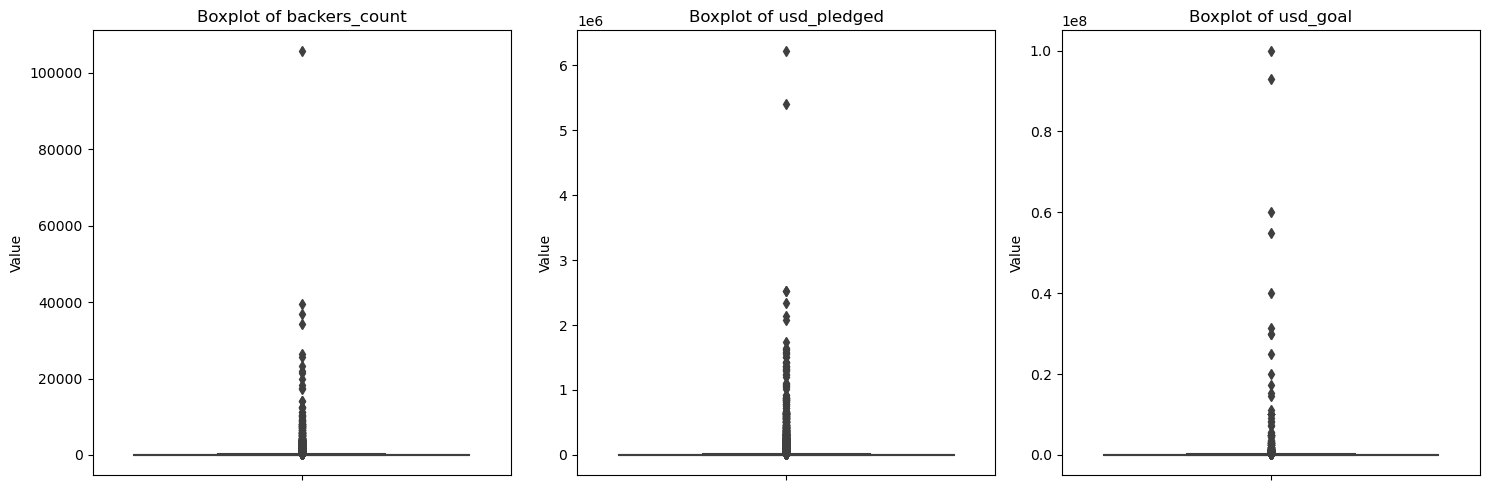

In [7]:
fig, axes = plot_boxplots(df, fundingcols, n_cols=3)
plt.show()

In [23]:
fundingextremes = pd.DataFrame()

# Loop through the columns, get the top 5, tag the source, and concatenate
for col in fundingcols:
    top_df = df.nlargest(5, col).copy() 
    top_df['source'] = col  # Tag the source before concatenating
    fundingextremes = pd.concat([fundingextremes, top_df], ignore_index=True)
# Not dropping duplicates in order to note if same record is an outlier in multiple ways

In [24]:
fundingextremes[['state', 'country', 'staff_pick', 'spotlight', 'category', 'source']]

,state,country,staff_pick,spotlight,category,source
0,successful,US,True,True,Web,backers_count
1,successful,US,True,True,Hardware,backers_count
2,successful,US,True,True,Hardware,backers_count
3,successful,US,True,True,Uncategorized,backers_count
4,successful,US,True,True,Hardware,backers_count
5,successful,US,True,True,Sound,usd_pledged
6,successful,US,True,True,Web,usd_pledged
7,successful,US,True,True,Sound,usd_pledged
8,successful,GB,True,True,Uncategorized,usd_pledged
9,successful,US,True,True,Hardware,usd_pledged


**Observations**
* For each of the funding variables, there are a only handful of data points causing the signficant skew. Taking a closer look at these cases, we find that none are in a cancelled or suspended state that would easily disqualify them as invalid records. Indeed, most are Staff Picks & Spotlighted, signalling legitimacy of the projects and an expectation or hope that such projects would be on the platform.
* The projects which failed and were not priviledged by Kickstarter are those which were in the top 5 in terms of goals - aspiration - instead of amount pledged or backers - verfiable success. That said, this does not preclude such projects from being considered as part of the kickstarter project portfolio. 
* Without reasonable grounds to exclude these outliers, potential solutions when clustering could be to apply log transformations on these variables, construct a seperate clustering model for projects with highly positive values for funding variables, or construct models with and without these outliers and compare the results.

**Examining data distribution excluding outliers**

In [7]:
for col in fundingcols:
    withiniqr = filter_iqr(df, col)
    print(f"Percentage of records for {col} outside IQR: {1 - len(withiniqr) / df.shape[0]}")

Percentage of records for backers_count outside IQR: 0.14715005816207838
Percentage of records for usd_pledged outside IQR: 0.15897634742148115
Percentage of records for usd_goal outside IQR: 0.08536900607470599


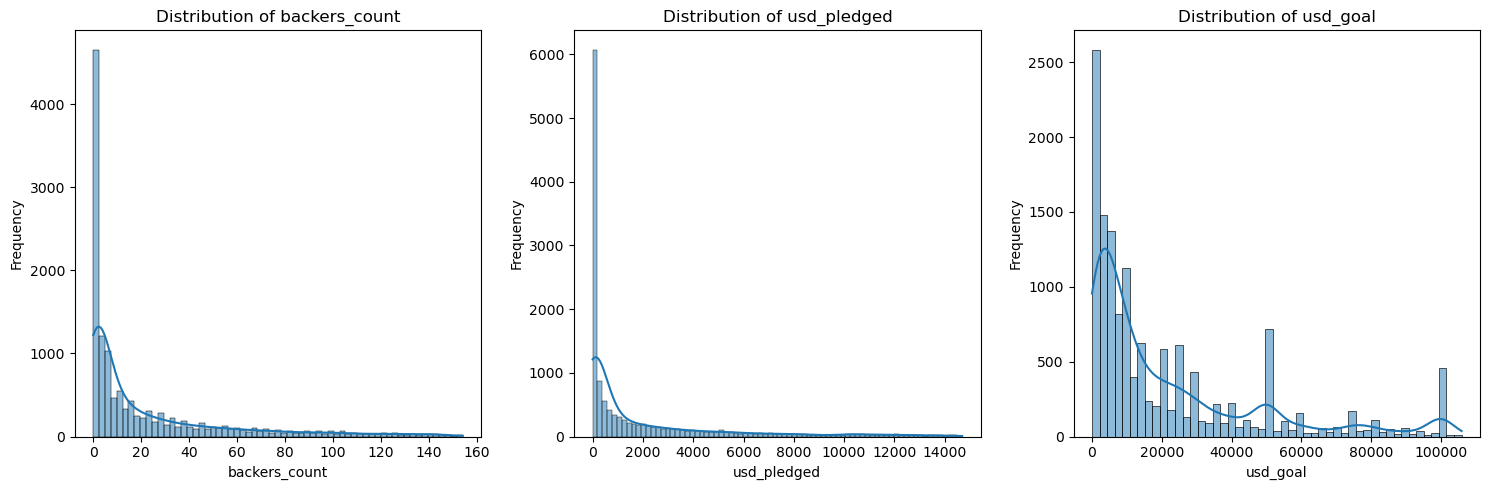

In [9]:
fig, axes = plot_IQRhistograms(df, fundingcols, kde=True, n_cols=3)
plt.show()

**Observations**
* Even when considering the data with extreme values removed via the IQR method, a clear right skew is still observed. The notable positive skew appears to simply be the nature of the underlying data distribution for these variables. 
* Viewing the percentage of records outside IQR provides context that it is a nontrivial portion of the sample being excluded when looking at the adjusted data distributions. However, this pared down view does allow for some patterns to be observed with `usd_goal`. Namely that is multimodal. Most projects appear clustered in the 0 to $200,000 range. But more modest peaks appear around $500,000 and around $1MM. Potentially these higher values are easily-conceptialized "moonshot" goals towards which a campaign's community may be inspired. 


#### Analyzing Categorical Variables

In [12]:
# check number of unique values for categorical variables
for col in catcols:
    num_unique_values = df[col].nunique()
    print(f"Number of unique values in {col}: {num_unique_values}")

Number of unique values in state: 4
Number of unique values in disable_communication: 2
Number of unique values in country: 18
Number of unique values in currency: 10
Number of unique values in staff_pick: 2
Number of unique values in category: 24
Number of unique values in spotlight: 2


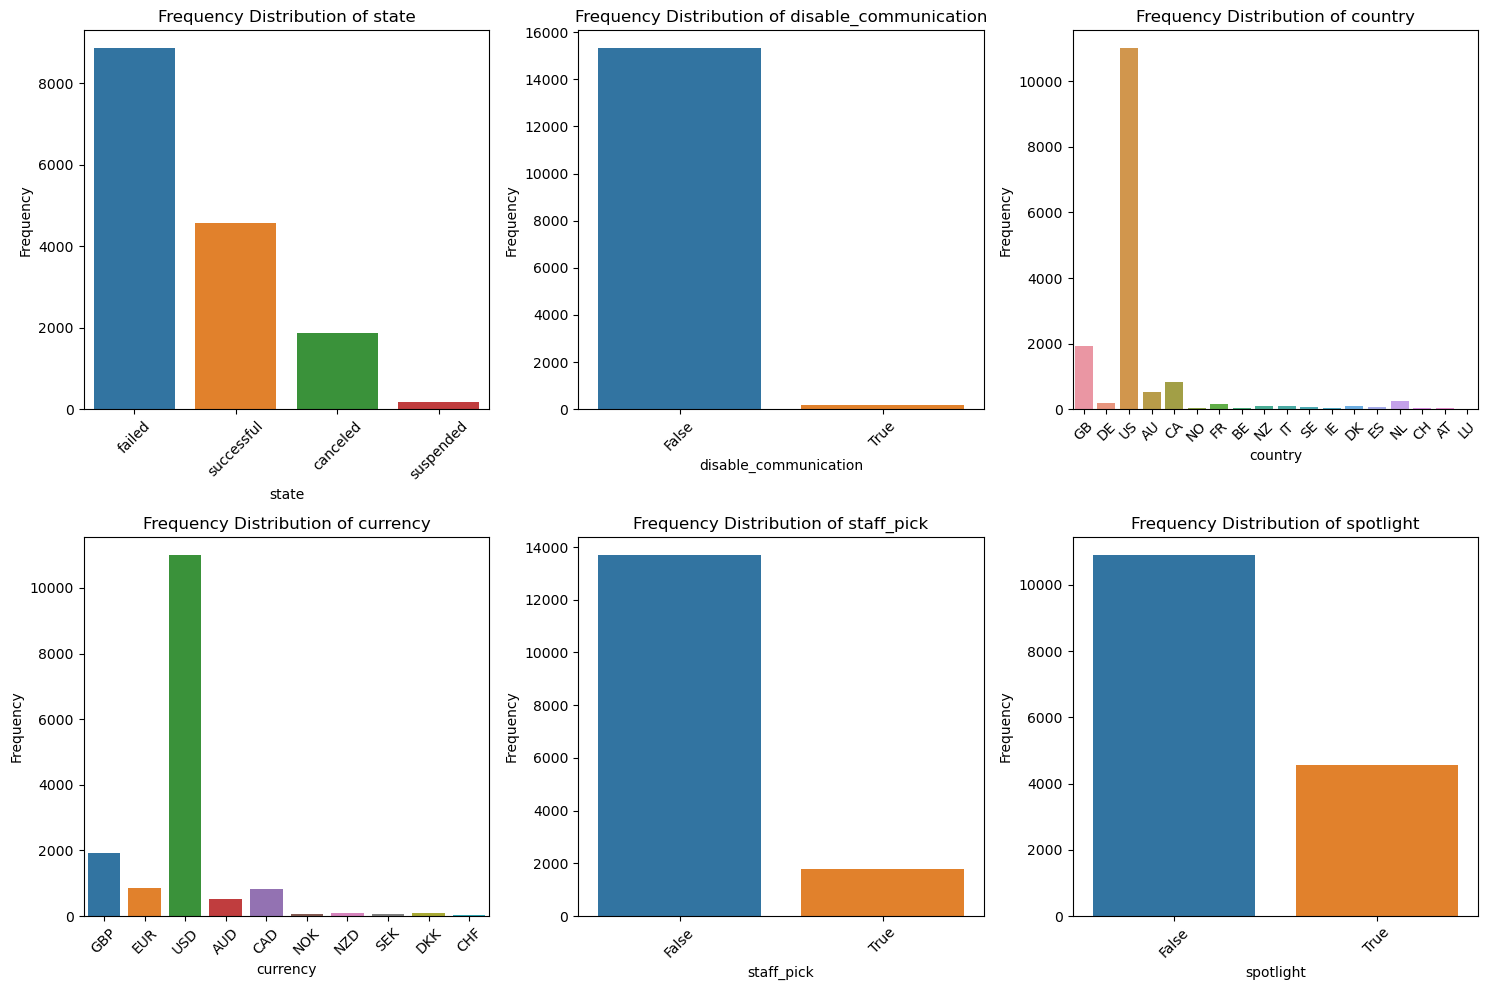

In [12]:
filteredcols = [col for col in catcols if col != "category"]
fig,axes = plot_freq_dist(df, filteredcols, n_cols = 3)
plt.show()

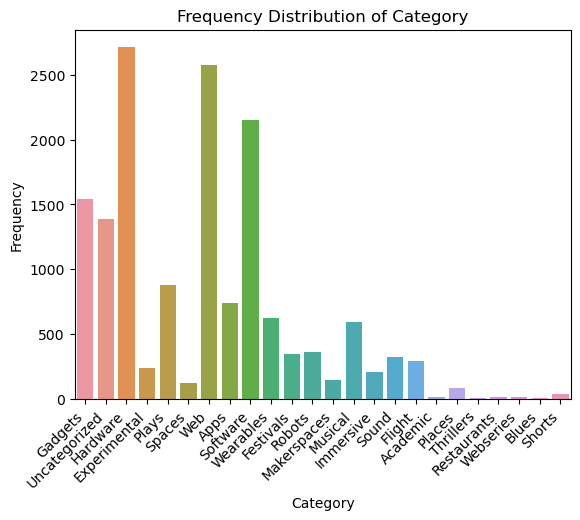

In [15]:
ax = sns.countplot(data=df, x="category")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Frequency Distribution of Category')
ax.set_xlabel('Category')
ax.set_ylabel('Frequency')
plt.show()

**Observations**
* `country`, `currency`, and `category` are potentially useful variables which have higher cardinality compared to the other categorical variables. With `currency` and `country` having similar distributions and conveying similar information but `currency` having lower cardinality, it may be the feature more amenable to later ML modeling. `category` will require some feature engineering to make it easier to use.
* Roughly twice as many failed projects as successful, which is on par with the roughly [50% success rate](https://www.startups.com/library/expert-advice/key-crowdfunding-statistics#:~:text=The%20average%20success%20rate%20of,crowdfunding%20campaigns%20exceed%20their%20goal.) for crowd funding campaigns worldwide.
* The US is the predominant source of Kickstarter projects, which aligns with expectations for an American platform. The United Kingdom holds a distant second place, yet it still contributes significantly more projects than other notable countries such as Canada, Australia, the Netherlands, and Denmark.
* Roughly 30% of projects are spotlighted on the platform while 15% are recognized as staff picks. With the assumption that these represent a diverse range of projects, these relative proportions appear reasonable.

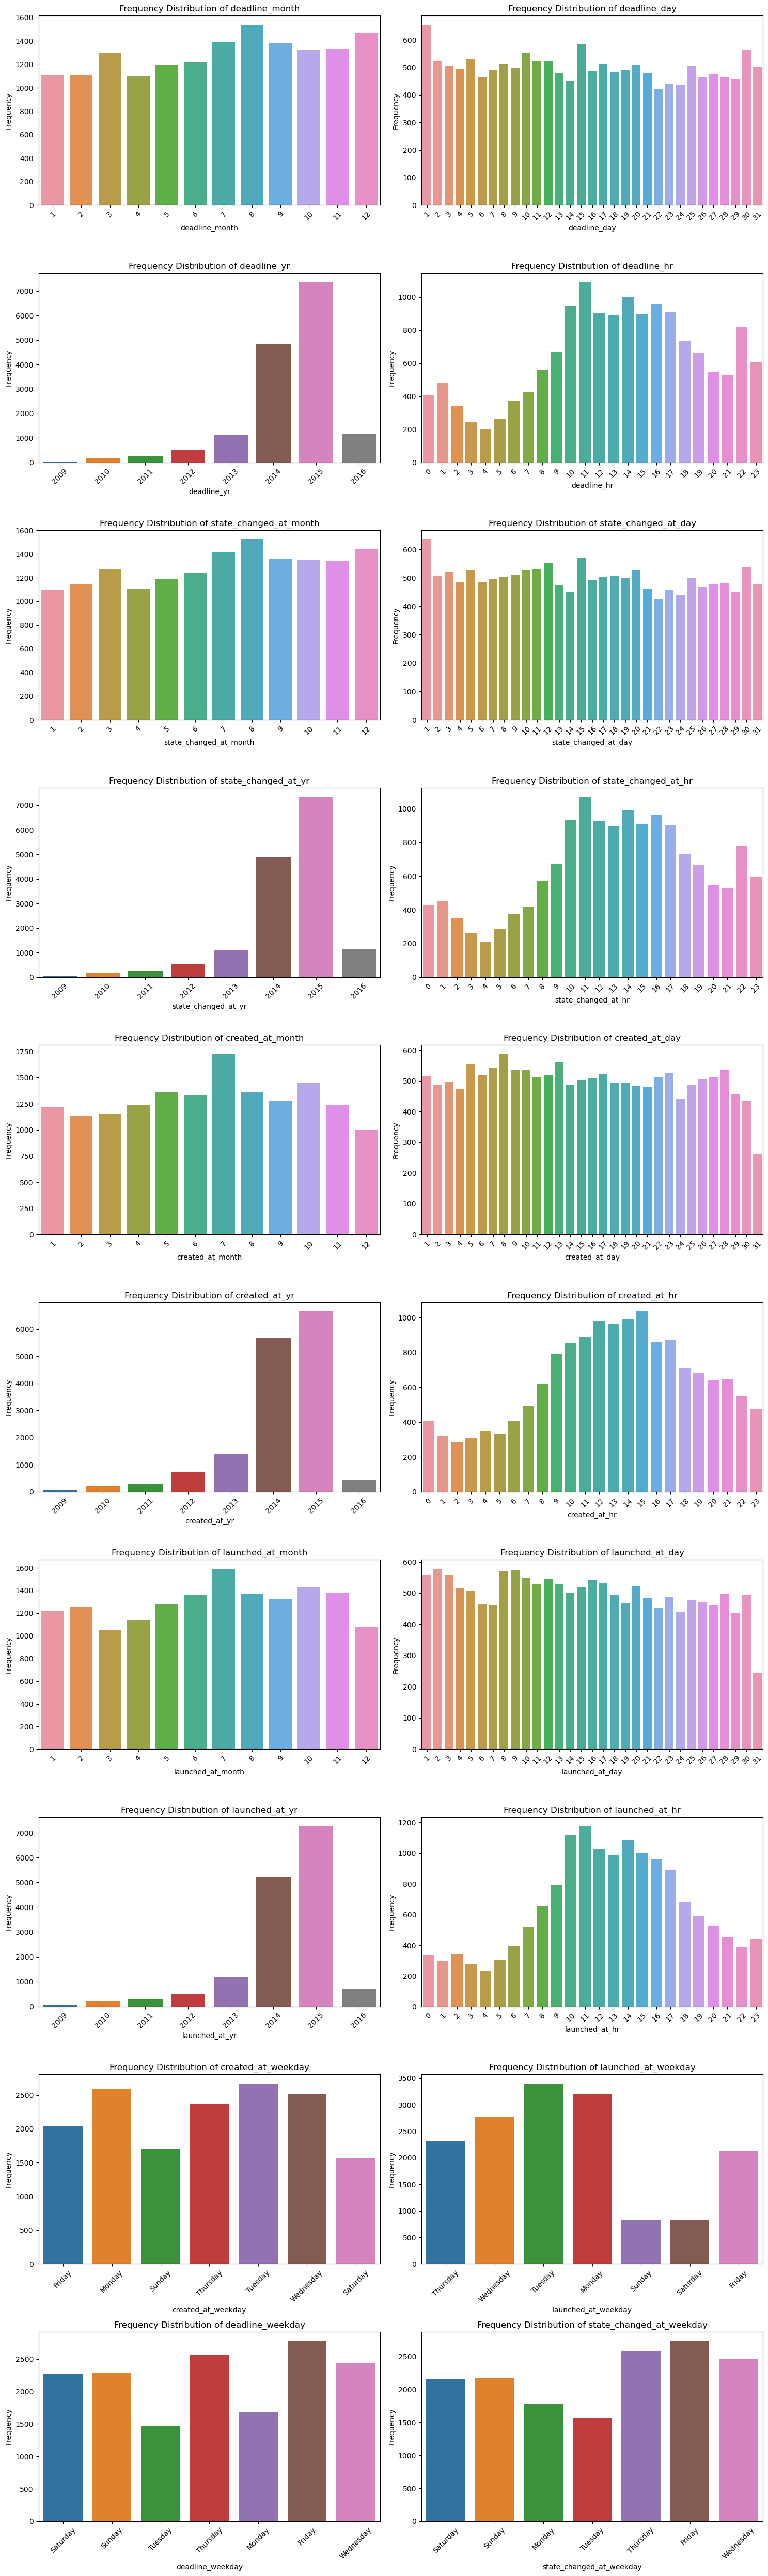

In [16]:
fig,axes = plot_freq_dist(df, datetimecols, n_cols = 2)
plt.show()

**Observations**
* The uniform distribution of projects across days suggests that day variables may have limited predictive value for ML model development, even when aggregated into larger segments of the month.
* The years 2014 and 2015 have the highest representation in the dataset, which could be attributed to the data collected. If a notable difference in the data distribution for these years and sufficient data volume, it may be worthwhile to focus clustering analysis on these years specifically. 
* There is a marked increase in project creation in July, warranting further investigation in bivariate analysis. 
* Weekday launches are much more common than weekend launches. This could signal weekends as a period of lower activity for creators or an expectation from creators of lower traffic from potential backers. 

### Bivariate Analysis

#### Basic Checks

In [7]:
# checking if currency always matches with country
df['cc'] = df['country'] + df['currency']
df['cc'].unique() # currency for fundraising does not differ in the same country. No extra information captured having both the country and currency variable. 

array(['GBGBP', 'DEEUR', 'USUSD', 'AUAUD', 'CACAD', 'NONOK', 'FREUR',
       'BEEUR', 'NZNZD', 'ITEUR', 'SESEK', 'IEEUR', 'DKDKK', 'ESEUR',
       'NLEUR', 'CHCHF', 'ATEUR', 'LUEUR'], dtype=object)

In [8]:
df.drop("cc", axis=1, inplace=True)

**Observations**

The association of `currency` with `country` was examined to determine if there were any instances where the currency for fundraising differed in the same country. No such case was found, meaning that there is no extra information captured by preserving both variables in a model. It is worth noting that the high cardinality in `country` compared to `currency` could make `currency` a helpful proxy variable for geographic factors.

#### Variables by Year

In [9]:
df_2014 = df[df["created_at_yr"] == 2014]
df_2015 = df[df["created_at_yr"] == 2015]
df_otheryrs = df[~df["created_at_yr"].isin([2014, 2015])]

might be better to create a categorical tag for the year and plot multiple on one chart? orrr do bivariate analysis of whole dataset via scatter plot then add color coding to see if similar pattern? 
ultimately it's just a sense check on if the nature of the platform has stayed similar enough across those years to analyze the dataset together. not sure how big of an impact this makes though.

maybe this should actually be a data drift test?

In [13]:
df['YearCategory'] = df['created_at_yr'].apply(lambda x: '2014' if x == 2014 else ('2015' if x == 2015 else 'Other Years'))

In [14]:
numcols

['backers_count',
 'usd_pledged',
 'blurb_len',
 'blurb_len_clean',
 'create_to_launch_days',
 'launch_to_deadline_days',
 'launch_to_state_change_days',
 'usd_goal',
 'name_len2',
 'name_len_clean_2']

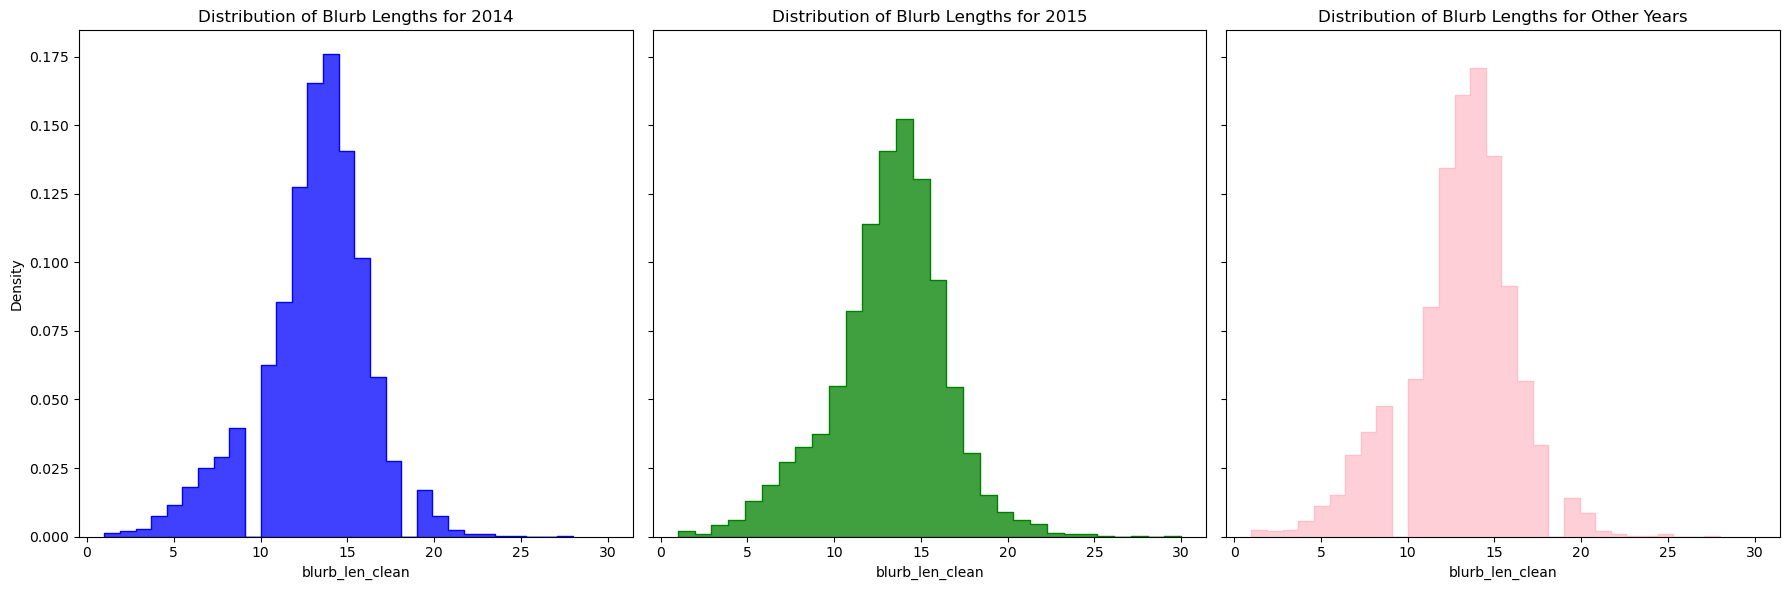

In [16]:
# create a function for doing histrograms by category. if i can't think of a better way. wait, i kind of have this below already with the kde plots. can adapt. 

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)  # 1 row, 3 columns
categories = ['2014', '2015', 'Other Years']
colors = ['blue', 'green', 'pink']  # Example colors

# Loop through the categories and plot each histogram
for ax, category, color in zip(axes, categories, colors):
    subset = df[df['YearCategory'] == category]
    sns.histplot(subset['blurb_len_clean'], ax=ax, color=color, element='step', stat='density', bins=30)
    ax.set_title(f'Distribution of Blurb Lengths for {category}')
    ax.set_xlabel('blurb_len_clean')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:

sns.scatterplot(data=df, x='blurb_len_clean', y='Frequency', hue='YearCategory', palette='viridis')
plt.title('Comparison of Blurb Length across Different Years')
plt.show()

*Observations - First Pass*

* As seen in univariate analysis, the bulk of records are from 2014 and 2015. Let's see if any major difference in data distributions / patterns for records from 2014, from 2015, and from other years

In [39]:
# i think the only scenario i'm dropping an outlier entirely is if it's also a suspended project. so it's probaby in the bivariate analysis that I'll make a call

In [ ]:
# vary other veriables with year
# vary other variables with state 

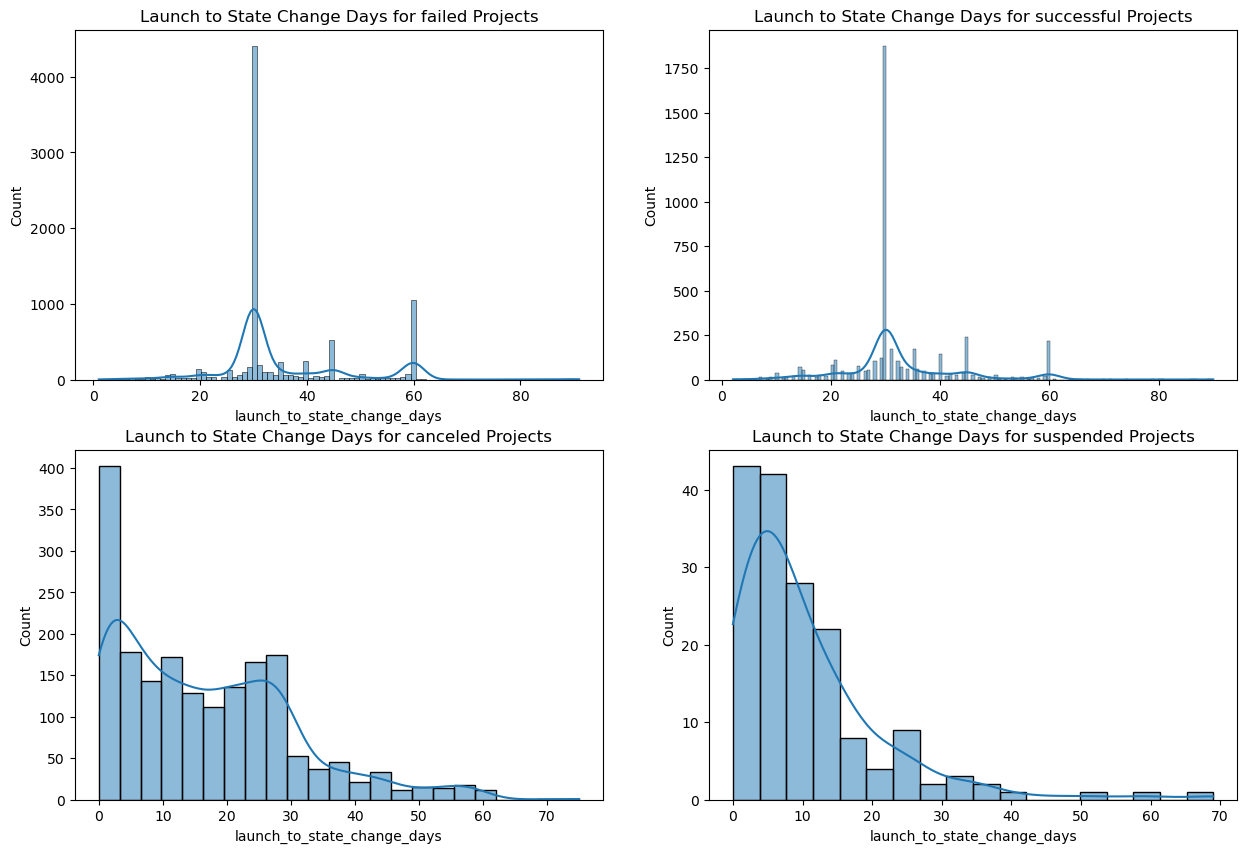

In [16]:
# launch to status change histograms broken out by status 
unique_states = df['state'].unique()
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration if it's multidimensional
axes = axes.flatten() if n_rows > 1 else [axes]

# Iterate through each unique state and plot the histogram
for i, state in enumerate(unique_states):
    state_data = df[df['state'] == state]['launch_to_state_change_days']
    
    # Plot the histogram
    sns.histplot(state_data, kde=True, ax=axes[i])
    
    # Set the title for each subplot
    axes[i].set_title(f'Launch to State Change Days for {state} Projects')

* Similar distributions for the number of days it takes for a project to enter status failed or successful. Both multimodal with peaks around the same number of days: 30, 45, and 60. Also similar ranges. This may indicate the typical campaign durations. This can be verified by checking number of days between when projects tend to be launched and their deadline. Plots below validate this hypothesis. Same distribution. The similarity in distribution in days to state change here is from projects coming to a natural close as planned at launch. 
* Days to cancel project is right-skewed with the mode near 0. This may be due to the fact that certain elements of a project cannot be edited after launch for maintaining accountability. Thus, if there's a real error, the user must cancel to make such changes. There's also another peak around 30 days. This may be users cancelling projects if it appears the project will fail **test this later**
* For suspended projects, there is a more signifanct right skew and some gaps in the distribution between ~40 and 70 days. The clusteering between 0 and 10 days shows mechanisms for spotting proejects which do not align with the nature of Kickstarter are working quite well.

In [8]:
# Ensuredatetime column
df['launched_at'] = pd.to_datetime(df['launched_at'])
df['deadline'] = pd.to_datetime(df['deadline'])

# Extract only the date part
df['launched_at_date'] = df['launched_at'].dt.date
df['deadline_date'] = df['deadline'].dt.date

# Calculate the planned duration in days
df['planned_duration'] = (df['deadline'] - pd.to_datetime(df['launched_at_date'])).dt.days

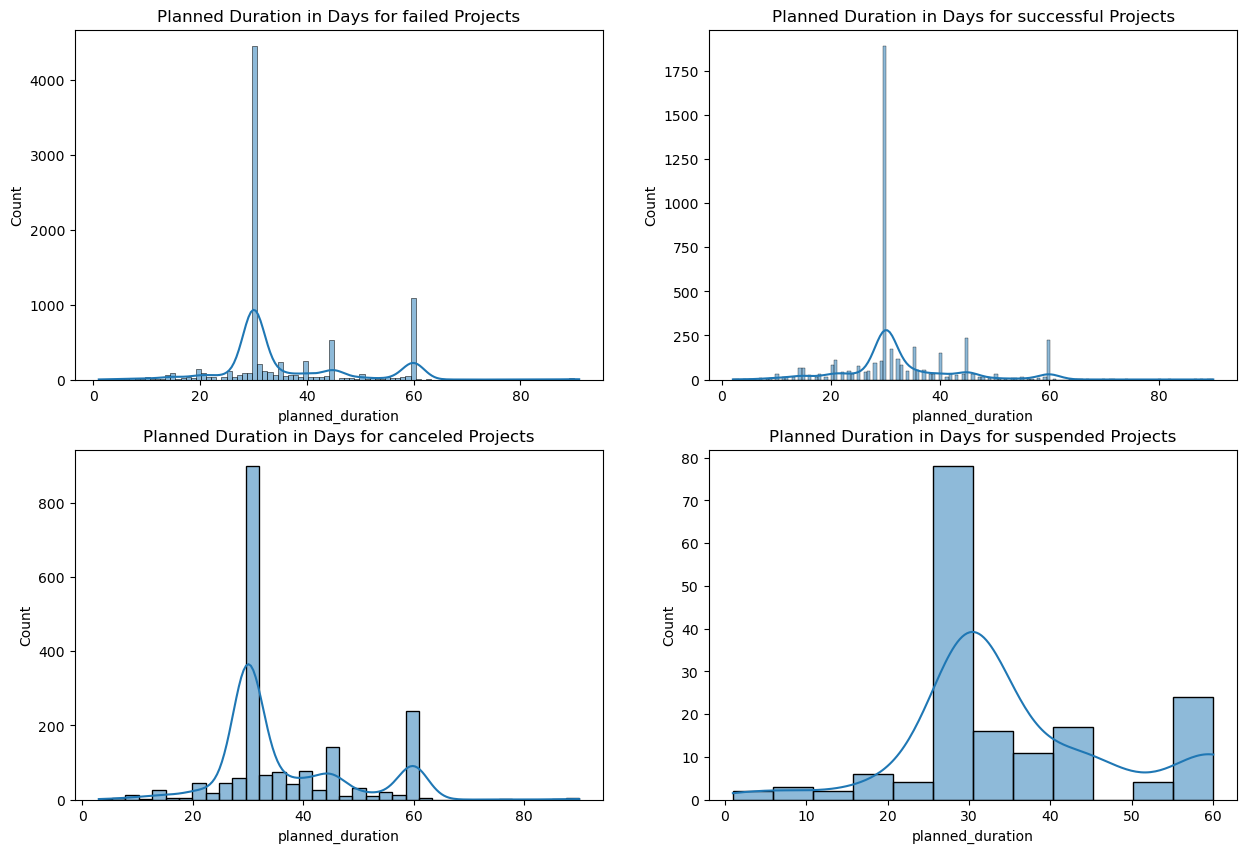

In [34]:

unique_states = df['state'].unique()
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration if it's multidimensional
axes = axes.flatten() if n_rows > 1 else [axes]

# Iterate through each unique state and plot the histogram
for i, state in enumerate(unique_states):
    state_data = df[df['state'] == state]['planned_duration']
    
    # Plot the histogram
    sns.histplot(state_data, kde=True, ax=axes[i])
    
    # Set the title for each subplot
    axes[i].set_title(f'Planned Duration in Days for {state} Projects')

* Projects which were cancelled have a similar planned duration to those who went their full length, indicating similar practices being followed across the platform for duration. (confirm if kickstarter has suggested durations. This could validate that this is being largely followed)

In [ ]:
# create version of dataset with encoded categoricals and normalized numerical, perform 2 component PCA and plot for an initial idea of whether there are clusters present
# make commentary, but don't abandon clustering yet

In [ ]:
# pairplots for all the numerical variables, see if any relationships to observe. 
# especially among variables which seemed to have meaningful divides in the univariate analysis

### Multivariate Analysis

In [ ]:
# correlation martrix for numerical
# chi-square tests for categorical

In [ ]:
# check proportion of each categorical variable value that is in each state (mosaic plot)

In [ ]:
# interesting bivariate plots from earlier color coded by state

### Testing Assumptions
* What states are common in the projects which have a very long creaton to state change duration? are these projects ones that are dormant and are being suspended or cancelled?
* Are users cancelling projects that appear they might fail? Peak in cancellations aroudn 30 days. See if those also have planned duration of 30 days and how much of their goal was acheived by that time
* Any notable difference in observed patterns / conclusions by year? 
* Distribution of goals, categories, of staff pick and of spotlight (seperately) projects. perhaps this fits better with bivariate analysis